# Imports

removed checking if in CoLab

In [ ]:
#imports
from platform import python_version

#basic python stuff
import os
import json
from pathlib import Path

#basics from the SciPy Stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#colab stuff
from google.colab import drive

#data managing
from sklearn.model_selection import train_test_split
from skimage import io #read in images

#model
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from keras.optimizers import Adam

#progress bar
from tqdm.notebook import tqdm

In [ ]:
# settings

# implements progress_apply into pandas
tqdm.pandas(desc='Pandas_Progress')

In [ ]:
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

In [ ]:
# get access to google drive
drive.mount('/content/drive')

In [ ]:
# import local python files
import importlib.util

# https://github.com/maxvfischer/keras-image-segmentation-loss-functions
spec = importlib.util.spec_from_file_location("binary_losses", "/content/drive/MyDrive/ML_Project_Satellite_Images/binary_losses.py")
binary_losses = importlib.util.module_from_spec(spec)
spec.loader.exec_module(binary_losses)

# Hyperparameters

In [ ]:
# training parameters
sample_size = 5000
batch_size = 128
epochs = 30
test_size = 0.3
val_size = 0.3

random_state = 123

# image preprocessing
img_size = 128
anti_aliasing = True
resize_method = tf.image.ResizeMethod.BILINEAR
mask_threshold = 0.5

# model parameters
params = {
    'filter_start' : 16,
    'filter_factor' : 2,
    'filter_levels' : 5,
    'kernel_size' : 3,
    'activation' : 'relu',
    'kernel_initializer' : 'he_normal',
    'dropout' : 0.3,
    'pool_size' : 2,
    'output_activation' : 'sigmoid',
    'learning_rate' : 0.005,
    'loss' : 'binary_crossentropy',
    #'loss' : binary_losses.binary_balanced_cross_entropy(beta=0.1),
    'metrics' : ['accuracy']#,tf.keras.metrics.MeanIoU(num_classes=2)]
  }

# for model saving
model_name = 'skip_with_conv_5000_128px'

# Retrieve the Dataset

In [ ]:
# unzip the dataset
!unzip -n -q /content/drive/MyDrive/ML_Project_Satellite_Images/data/current_dataset.zip -d /content/

In [ ]:
# read in samples.csv with information about the images (only a sample)
samples_df = pd.read_csv('/content/dataset/samples.csv').sample(sample_size, random_state=random_state)
samples_df.set_index('id', inplace=True)
samples_df

In [ ]:
# paths to the sat/mask folder
path_sat_folder = '/content/dataset/images/satellite/'
path_mask_folder = '/content/dataset/images/mask/'

In [ ]:
# append absoulute paths of the images to the dataframe
samples_df['abs_satellite_path'] = samples_df['satellite_file'].apply(lambda x: path_sat_folder+x)
samples_df['abs_mask_path'] = samples_df['mask_file'].apply(lambda x: path_mask_folder+x)

# Prepare the tf.data.Dataset

- https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5  
- https://www.tensorflow.org/guide/data_performance


In [ ]:
def parse_satellite_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_size, img_size], method=resize_method, antialias=anti_aliasing)
  img = img / 255.
  return img

In [ ]:
def parse_mask_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_png(img, channels=4)
  img = tf.image.resize(img, [img_size, img_size], method=resize_method, antialias=anti_aliasing)
  img = img[:,:,2]
  img = img / 255.
  mask = tf.greater(img,mask_threshold)
  img = tf.where(mask, 1, 0)
  return img

In [ ]:
def make_dataset(samples_df, batch_size):
  # paths as Dataset
  satellite_paths_ds = tf.data.Dataset.from_tensor_slices(samples_df['abs_satellite_path'])
  mask_paths_ds = tf.data.Dataset.from_tensor_slices(samples_df['abs_mask_path'])
  # images as Dataset
  satellite_ds = satellite_paths_ds.map(parse_satellite_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  mask_ds = mask_paths_ds.map(parse_mask_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # combine inputs and targets https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
  ds = tf.data.Dataset.zip((satellite_ds, mask_ds))
  # configure the Dataset for better performance
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  ds = ds.cache()

  return ds

# Split Training, Validation and Test Data

In [ ]:
# split in (train+val) and test
samples_df_train_val, samples_df_test = train_test_split(samples_df, test_size=test_size, random_state=random_state)
# split (train+val)
samples_df_train, samples_df_val = train_test_split(samples_df_train_val, test_size=val_size, random_state=random_state)

In [ ]:
print('Training Shape: ',samples_df_train.shape)
print('Validation Shape: ',samples_df_val.shape)
print('Test Shape: ',samples_df_test.shape)

In [ ]:
train_ds = make_dataset(samples_df_train, batch_size)
val_ds = make_dataset(samples_df_val, batch_size)
test_ds = make_dataset(samples_df_test, batch_size)

In [ ]:
for x in train_ds.take(1):
  print(type(x[0]))
  plt.imshow(x[0][1])
  plt.show()
  plt.imshow(x[1][1])
  plt.show()

## Build model

 Sources:
 - https://keras.io/examples/vision/oxford_pets_image_segmentation/
 - https://keras.io/getting_started/intro_to_keras_for_engineers/#building-models-with-the-keras-functional-api
 - https://www.youtube.com/watch?v=azM57JuQpQI



 
 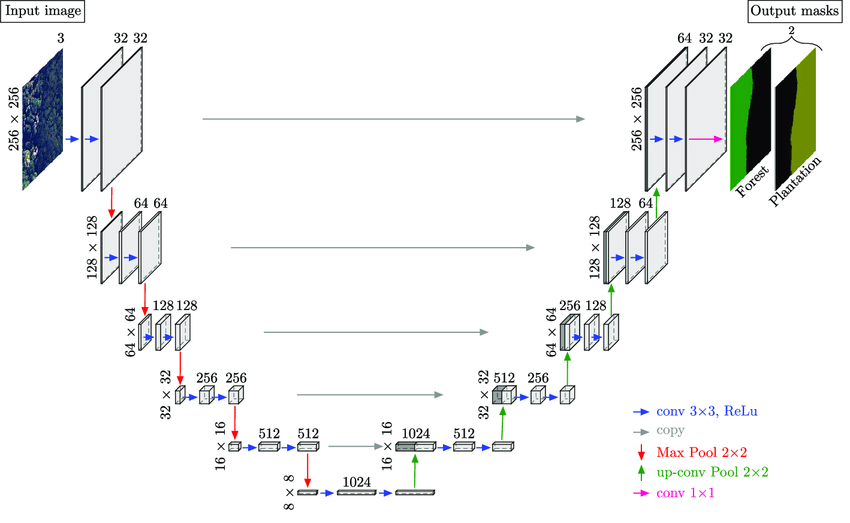

In [ ]:
def conv_layer(params,level):
  filters = params['filter_start'] * params['filter_factor'] ** level
  layer = layers.Conv2D(
                    filters = filters, 
                    kernel_size = params['kernel_size'],
                    activation = params['activation'],
                    padding = 'same',
                    kernel_initializer = params['kernel_initializer']
                    )
  return layer

def build_model(params):
  inputs = layers.Input((img_size, img_size, 3))

  last = inputs

  layers_to_copy = []

  # contraction path
  for level in range(params['filter_levels']-1):
    last = conv_layer(params, level)(last)
    last = layers.Dropout(params['dropout'])(last)
    last = conv_layer(params, level)(last)
    
    # convolution in the skip path
    skip_conv = layers.Dropout(params['dropout'])(last)
    skip_conv = conv_layer(params, level)(skip_conv)
    layers_to_copy.append(skip_conv)

    last = layers.MaxPool2D(pool_size=params['pool_size'])(last)

  # bottom level
  last = conv_layer(params, params['filter_levels']-1)(last)
  last = layers.Dropout(params['dropout'])(last)
  last = conv_layer(params, params['filter_levels']-1)(last)

  # large skip level
  skip = conv_layer(params, 0)(inputs)
  skip = layers.Dropout(params['dropout'])(skip)
  skip = conv_layer(params, 0)(skip)

  # expasion path
  for level in range(params['filter_levels']-2,-1,-1):
    filters = params['filter_start'] * params['filter_factor'] ** level
    #last = layers.UpSampling2D(size=(2,2))(last)
    last = layers.Conv2DTranspose(filters = filters, kernel_size=params['pool_size'], strides=params['pool_size'], padding='same')(last)
    last = layers.concatenate([last, layers_to_copy[level]])
    last = conv_layer(params, level)(last)
    last = layers.Dropout(params['dropout'])(last)
    last = conv_layer(params, level)(last)

  last = layers.concatenate([last, skip])
  last = conv_layer(params, 0)(last)

  outputs = layers.Conv2D(1, (1, 1), activation=params['output_activation'])(last)
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  optimizer = Adam(learning_rate=params['learning_rate'])
  model.compile(optimizer=optimizer, loss=params['loss'], metrics=params['metrics'])
  
  return model

In [ ]:
model = build_model(params)
model.summary()

In [ ]:
results = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs)

In [ ]:
def plot_history(network_history,figsize=(8,5)):
  history_keys = [key for key in network_history.history.keys() if not key.startswith('val_')]
  for key in history_keys:
    plt.figure(figsize=figsize)
    plt.plot(network_history.history[key])
    plt.plot(network_history.history[f'val_{key}'])
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_history(results)

In [ ]:
model.save(f'/content/drive/MyDrive/ML_Project_Satellite_Images/models/{model_name}.h5')

In [ ]:
sample_ids = {
    'train_ids':samples_df_train.index.to_list(),
    'val_ids':samples_df_val.index.to_list(),
    'test_ids':samples_df_test.index.to_list()
  }

In [ ]:
with open(f'/content/drive/MyDrive/ML_Project_Satellite_Images/models/{model_name}.json', 'w') as f:
    json.dump(sample_ids, f)

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')